### Forecasting with ARIMA

ARIMA stands for Auto Regressive Integrated Moving Average. The AR part of ARIMA indicates that the evolving variable of interest is regressed on its own past values.

Past is used to predict the future. ARIMA models are fitted to time series data in an attempt to understand the time series data and for forecasting.

Non-seasonal ARIMA(p,d,q) models have 3 parameters p, d, and q: p represents the number of time lags of the autoregressive model, d is the degree of differencing and q refers to the moving-average model. That is, AR(p) and MA(q). E.g. ARIMA (1,0,0) = AR(1) and ARIMA(0,0,1)= MA(1).

This notebook will go over how to fit ARIMA models with seasonality denoted SARIMA(p, d, q, P, D, Q, m).  The 'S' stands for 'Seasonal' and uppercase 'P', 'D', and 'Q'refer to the autoregressive, differencing and moving average terms for the seasonal part of the ARIMA model. The period m refers to the number of periods in each season.

#### Data

We use a copy of the airline passengers dataset available from R data package. 

We converted the floating point time representation to datetime using pandas to_datetime(). Then we changed it into a time series using df = df.set_index("time").


In [11]:
#imports

import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

In [68]:
# Load data

df = pd.read_csv('C:/Users/uknow/Desktop/ARIMA/data/AirPassengers.csv', index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [15]:
# Time series of air passengers per month - the 2 columns: Time (month) and Passenger 

df.columns

Index(['Passengers'], dtype='object')

In [16]:
# Look at the type, number of columns, entries, null values etc..
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
Passengers    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


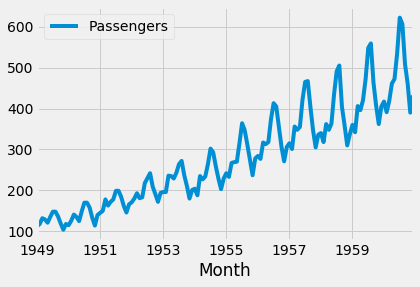

In [17]:
# There is a non-random oscillating seasonal component (period=12)

df.plot();

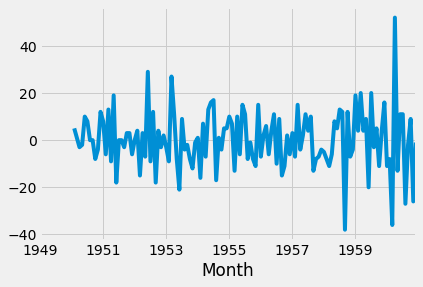

In [18]:
# Adding a seasonal differencing term to remove the trend 

df.Passengers.diff().diff(periods=12).plot();

We can find the value for AR(p) and MA(q) using the plots for autocorrelation and partial autocorrelation

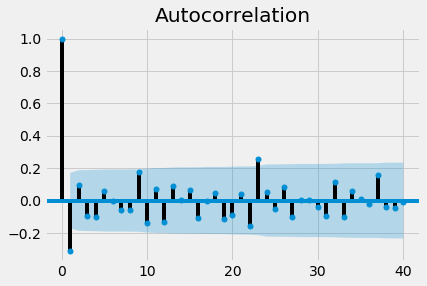

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

stationary_data = df['Passengers'].diff().diff(periods=12)[13:]
x = plot_acf(stationary_data, lags=40)

The above chart shows one significant autocorrelation at lag 1 and *possibly* another around lag 26.

But,the partial autocorrelation, we see a slightly different story:

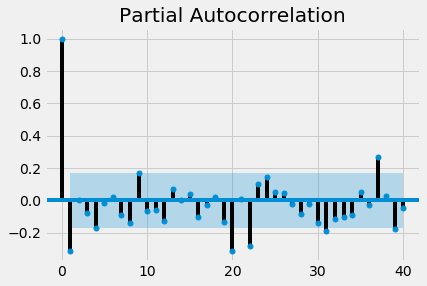

In [20]:
x = plot_pacf(stationary_data, lags=40)

A significant lag that routinely shows up every n number of lags shows up as a value of 1 when using it for a value of p or q.

Since these spikes occur using our autocorrelation plot, we'll infer that our *seasonal* autoregressive term p = 1.

We have:

 -  p=d=q=1
 - A seasonal differencing term, since using a seasonal lag of 12 gave us the most stationary time series.
 - Autocorrelation plot did not show a season moving average term
 - Partial autocorrelation plot shows a season autoregressive part, with the expected significant lag occurring ~ every 12 lags.
 


Our hypothetical model is:

### SARIMA(1, 1, 1, 1, 1, 0, 12)

### Fitting SARIMA models 

using statsmodels package

In [22]:
# import the model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit it using our derived terms
model = SARIMAX(df['Passengers'], order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))

# fit the model
res = model.fit()

C:\Users\uknow\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [23]:
# and now we'll print our results
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -507.178
Date:                            Thu, 07 Nov 2019   AIC                           1022.356
Time:                                    00:46:19   BIC                           1033.857
Sample:                                01-01-1949   HQIC                          1027.029
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2160      0.392     -0.551      0.582      -0.985       0.553
ma.L1         -0.0875      0.370   

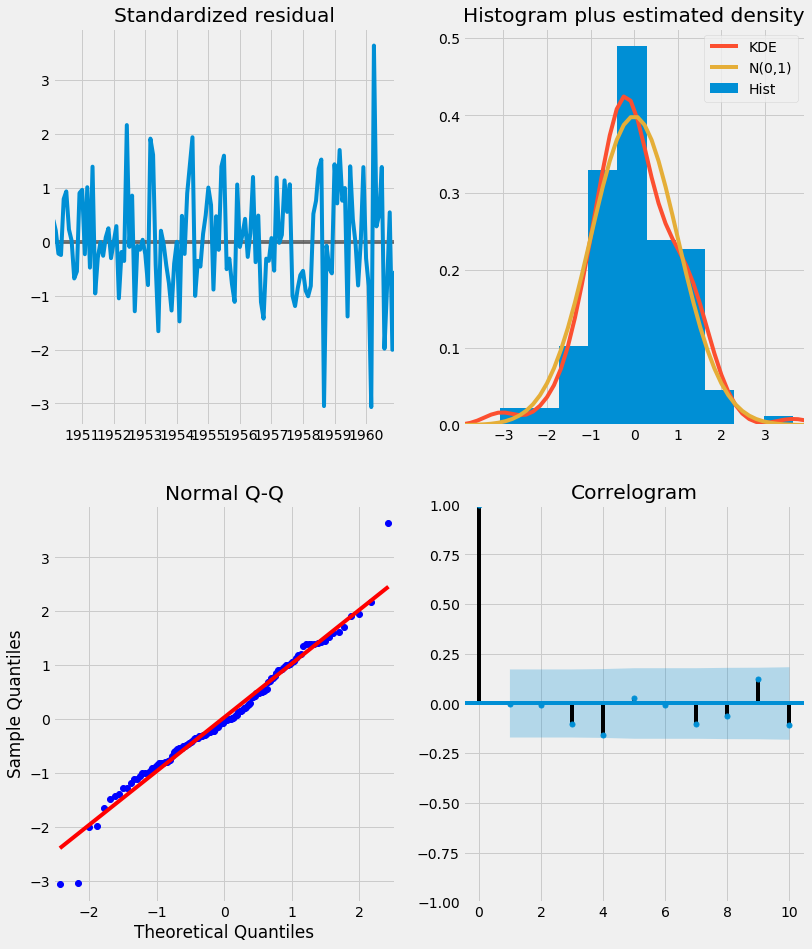

In [24]:
# Plot diagnostics on our residuals


x = res.plot_diagnostics(figsize=(12, 15))

In [25]:
# Look at the error metric
res.aic

1022.3557767685161

In [51]:
# Forecasting:

res.forecast(12)

1961-01-01    445.833828
1961-02-01    420.909278
1961-03-01    454.027736
1961-04-01    488.650104
1961-05-01    501.494418
1961-06-01    562.934221
1961-07-01    648.374179
1961-08-01    636.203434
1961-09-01    538.487084
1961-10-01    490.210663
1961-11-01    422.898099
1961-12-01    465.039924
Freq: MS, dtype: float64

In [31]:
# Confidence intervals

res.get_prediction(start='1961-01-01', end='1961-06-01', dynamic=False).conf_int()

,lower Passengers,upper Passengers
1961-01-01,423.090288,468.577367
1961-02-01,393.193587,448.624969
1961-03-01,421.339389,486.716084
1961-04-01,451.801357,525.498851
1961-05-01,460.880313,542.108524
1961-06-01,518.881214,606.987227


In [32]:
df.diff().diff(periods=12).describe()

,Passengers
count,131.000000
mean,0.183206
std,12.356749
min,-38.000000
25%,-7.500000
50%,0.000000
75%,9.000000
max,52.000000


Text(0.5, 1.0, 'Forecast Air Passengers')

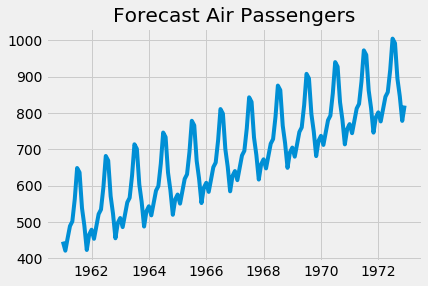

In [67]:
pred = pd.Series(res.forecast(144))
plt.plot(pred)
plt.title("Forecast Air Passengers")